# PROJECT: Emotion Classification from Public Opinion (IndoBERT)
## Notebook 01: Data Preparation & Exploratory Data Analysis (EDA)
- Author: Randra Ferdian Saputra
- Goal: Membersihkan data mentah, melakukan analisis distribusi data, dan membagi dataset (Train/Val/Test) untuk persiapan Fine-Tuning.

## **1. Setup Environment & Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
import json

# Konfigurasi Visualisasi
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-pastel') 

## **2. Data Ingestion (Pengumpulan Data)**

### 2.1. Define Label Mapping

In [3]:
# 1. Definisikan Mapping Label (Kamus Label)
label_map = {
    'AngerData': 0,      
    'FearData': 1,      
    'JoyData': 2,    
    'LoveData': 3,
    'NeutralData': 4,
    'SadData':5
}

### 2.2 Load & Merge Datasets

In [4]:
# 2. Lokasi folder data mentah kamu
raw_data_path = '../Datasets/raw'

all_dataframes = []

# 3. Membaca File
for filename, label_code in label_map.items():
    file_path = os.path.join(raw_data_path, f"{filename}.csv") 
    if os.path.exists(file_path):
        print(f"Sedang memproses file: {filename} ... label: {label_code}")
        df_temp = pd.read_csv(file_path, sep=None, engine='python', on_bad_lines='skip')
        df_temp.columns = df_temp.columns.str.strip()
        if 'Tweet' in df_temp.columns:
            df_temp = df_temp.rename(columns={'Tweet': 'text'})
            df_temp.dropna(subset=['text'], inplace=True)
            df_temp['label'] = label_code
            all_dataframes.append(df_temp[['text', 'label']])
    else:
        print(f"⚠️ Warning: File {filename}.csv tidak ditemukan di {raw_data_path}")

# 4. Gabungkan semua menjadi satu (Concatenate)
if all_dataframes:
    full_df = pd.concat(all_dataframes, ignore_index=True)
    
    # 5. BERSIH-BERSIH (Preprocessing Sederhana)
    full_df.dropna(subset=['text'], inplace=True)
    full_df['text'] = full_df['text'].str.lower()
    
    # 6. ACAK DATA (Shuffle) - PENTING!
    full_df = shuffle(full_df, random_state=42).reset_index(drop=True)

    # Cek distribusi data
    print("\nJumlah data per label:")
    print(full_df['label'].value_counts())

    # 7. Simpan ke folder processed
    output_path = '../Datasets/processed/dataset_gabungan.csv'
    # Pastikan folder ada
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    full_df.to_csv(output_path, index=False)
    print(f"\n✅ Sukses! Data gabungan tersimpan di: {output_path}")

else:
    print("Tidak ada data yang berhasil diproses.")

Sedang memproses file: AngerData ... label: 0
Sedang memproses file: FearData ... label: 1
Sedang memproses file: JoyData ... label: 2
Sedang memproses file: LoveData ... label: 3
Sedang memproses file: NeutralData ... label: 4
Sedang memproses file: SadData ... label: 5

Jumlah data per label:
label
4    1964
2    1272
0    1122
5     999
1     908
3     751
Name: count, dtype: int64

✅ Sukses! Data gabungan tersimpan di: ../Datasets/processed/dataset_gabungan.csv


### 2.3 Initial Data Check

In [5]:
# 1. Cek sampel acak (Apakah label sudah campur?)
print("=== Sampel 5 Data Acak ===")
display(full_df.sample(5))

# 2. Cek Info Tipe Data & Missing Values
print("\n=== Info DataFrame ===")
full_df.info()

# 3. Cek Distribusi Label (Apakah semua file masuk?)
print("\n=== Jumlah Data per Label ===")
# 0: Anger, 1: Happy, dst (sesuai mapping kamu)
full_df['label'].value_counts()

=== Sampel 5 Data Acak ===


,text,label
3954,halahh cuma bisa memenangkan pilkada lewat isu...,4
959,yg bego gue maraton baca seminggu doang di wt ...,0
4905,"vitamin, susu, makanan yg enak",4
6979,"sering-sering bikin au taeyong yaakk, seruu! s...",2
1134,most noticed kulit jadi lebih halus. pori-pori...,3



=== Info DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7016 entries, 0 to 7015
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7016 non-null   object
 1   label   7016 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 109.8+ KB

=== Jumlah Data per Label ===


label
4    1964
2    1272
0    1122
5     999
1     908
3     751
Name: count, dtype: int64

## **3. Text Preprocessing**

### 3.1 Load Normalization Dictonary

In [6]:
url_kamus_alay = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"

print("⏳ Sedang mendownload kamus alay...")
try:
    df_kamus = pd.read_csv(url_kamus_alay)
    norm_dict = dict(zip(df_kamus['slang'], df_kamus['formal']))
    
    print(f"✅ Berhasil! Kamus alay dengan {len(norm_dict)} kata siap digunakan.")
    print(f"   Contoh: 'bgt' -> {norm_dict.get('bgt')}")
    print(f"   Contoh: 'anj' -> {norm_dict.get('anj')}")

except Exception as e:
    print(f"❌ Gagal download: {e}")

⏳ Sedang mendownload kamus alay...
✅ Berhasil! Kamus alay dengan 4331 kata siap digunakan.
   Contoh: 'bgt' -> banget
   Contoh: 'anj' -> anjing


### 3.2 Define Cleaning Function

In [7]:
def clean_text(text):
    # 1. Pastikan input adalah string (jaga-jaga ada data angka/float)
    text = str(text)
    # 2. Lowercase (Ubah ke huruf kecil semua)
    text = text.lower()
    # 3. Hapus URL (http/https/www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 4. Hapus Mention (@username) - Mengurangi noise & menjaga privasi
    text = re.sub(r'@\w+', '', text)
    # 5. Hapus Simbol Hashtag (#) tapi BIARKAN kata di belakangnya
    text = re.sub(r'#', '', text)
    # 6. Hapus Angka & Tanda Baca (Hanya sisakan huruf a-z dan spasi)
    text = re.sub(r'[^a-z\s]', '', text)
    # 7. Normalisasi Kata Alay (Mapping pakai norm_dict yg tadi didownload)
    words = text.split()
    # Logika: "Ambil kata baku dari kamus jika ada, jika tidak ada pakai kata aslinya"
    cleaned_words = [norm_dict.get(word, word) for word in words]
    text = " ".join(cleaned_words)
    # 8. Hapus Spasi Berlebih (Double space)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### 3.3 Apply Cleaning

In [8]:
print("⏳ Sedang membersihkan seluruh dataset... Mohon tunggu sebentar.")

# 1. Terapkan fungsi clean_text ke kolom 'text'
full_df['text_clean'] = full_df['text'].apply(clean_text)

# 2. Hapus Duplikat SETELAH cleaning
initial_count = len(full_df)
full_df.drop_duplicates(subset=['text_clean'], inplace=True)
print(f"📉 Menghapus {initial_count - len(full_df)} data duplikat setelah cleaning.")

# 3. Hapus Data Kosong (Empty Strings)
full_df['text_clean'].replace('', np.nan, inplace=True)
nan_count = full_df['text_clean'].isna().sum()

if nan_count > 0:
    full_df.dropna(subset=['text_clean'], inplace=True)
    print(f"🗑️ Menghapus {nan_count} baris yang menjadi kosong (hanya berisi simbol/link).")

# 4. Reset Index agar rapi kembali
full_df = full_df.reset_index(drop=True)

print("✅ Selesai! Data sudah bersih.")

# === CEK HASILNYA ===
print("\n=== Perbandingan Before vs After (5 Sampel Acak) ===")
# Tampilkan kolom text asli, text_clean, dan label
display(full_df[['text', 'text_clean', 'label']].sample(5))

print(f"\nJumlah total data bersih sekarang: {len(full_df)}")

⏳ Sedang membersihkan seluruh dataset... Mohon tunggu sebentar.
📉 Menghapus 118 data duplikat setelah cleaning.
✅ Selesai! Data sudah bersih.

=== Perbandingan Before vs After (5 Sampel Acak) ===


C:\Users\Victus\AppData\Local\Temp\ipykernel_2736\2649154891.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['text_clean'].replace('', np.nan, inplace=True)


,text,text_clean,label
6524,tetap jadi org yg bahagia sebab setan itu data...,tetap jadi orang yang bahagia sebab setan itu ...,4
6600,sedih mart mu takde piala musim ni,sedih mart mu takde piala musim nih,5
2196,aku belum jadi sekolah ilmu komunikasi politik...,aku belum jadi sekolah ilmu komunikasi politik...,5
913,bismillah masih semangat masih optimis yakin b...,bismillah masih semangat masih optimis yakin b...,2
1935,sp tau bangun kaget,sapa tau bangun kaget,4



Jumlah total data bersih sekarang: 6898


## **4. Exploratory Data Analysis**

### 4.1 Label Distribution

C:\Users\Victus\AppData\Local\Temp\ipykernel_2736\801216873.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_df, x='label_name', palette='viridis', order=full_df['label_name'].value_counts().index)


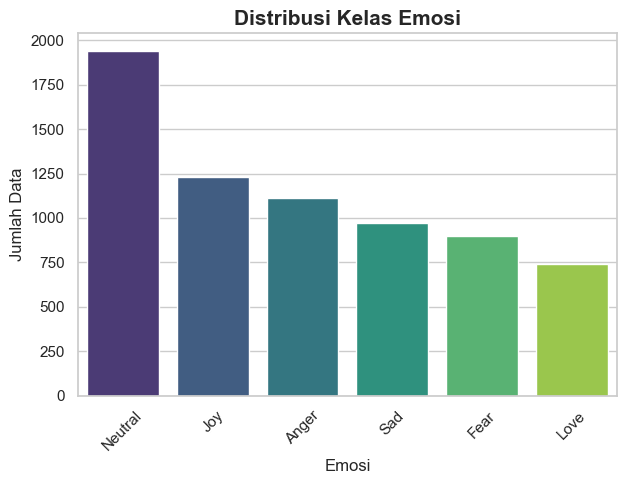

In [9]:
# --- A. Membuat Mapping Nama Label ---
reverse_map = {
    0: 'Anger',
    1: 'Fear',
    2: 'Joy',
    3: 'Love',
    4: 'Neutral',
    5: 'Sad' 
}
full_df['label_name'] = full_df['label'].map(reverse_map)


plt.figure(figsize=(12, 5))
# --- B. Plot Distribusi Label ---
plt.subplot(1, 2, 1)
sns.countplot(data=full_df, x='label_name', palette='viridis', order=full_df['label_name'].value_counts().index)
plt.title("Distribusi Kelas Emosi", fontsize=15, fontweight='bold')
plt.xlabel("Emosi")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 4.2 text Length Analysis

=== Statistik Panjang Kalimat ===
count    6898.000000
mean       16.544941
std        12.686587
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max        58.000000
Name: num_words, dtype: float64

95% kalimat memiliki panjang di bawah: 43 kata
99% kalimat memiliki panjang di bawah: 49 kata


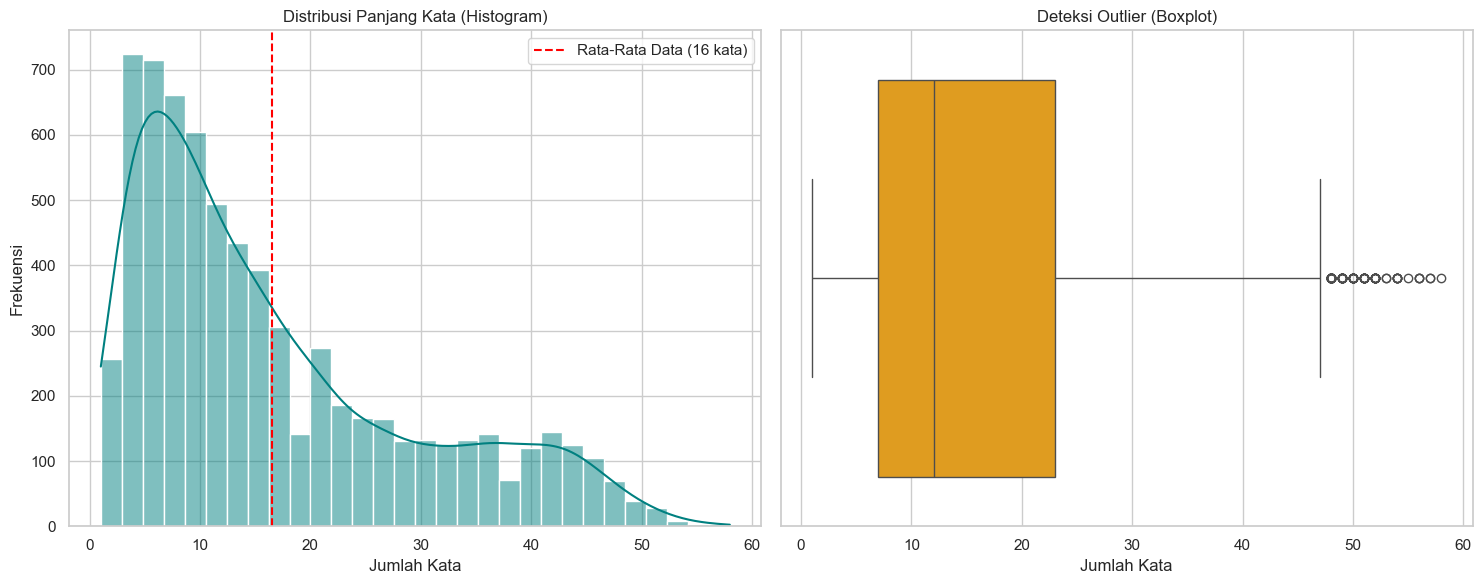

In [10]:
full_df['num_words'] = full_df['text_clean'].apply(lambda x: len(str(x).split()))

# 2. Statistik Deskriptif
print("=== Statistik Panjang Kalimat ===")
print(full_df['num_words'].describe())

# Cari tahu berapa panjang yang mencakup 99% data
quantile_95 = full_df['num_words'].quantile(0.95)
quantile_99 = full_df['num_words'].quantile(0.99)
mean_data = full_df['num_words'].mean()
print(f"\n95% kalimat memiliki panjang di bawah: {int(quantile_95)} kata")
print(f"99% kalimat memiliki panjang di bawah: {int(quantile_99)} kata")

# 3. Visualisasi (Histogram & Boxplot)
plt.figure(figsize=(15, 6))

# Histogram (Sebaran Data)
plt.subplot(1, 2, 1)
sns.histplot(full_df['num_words'], bins=30, kde=True, color='teal')
plt.axvline(mean_data, color='red', linestyle='--', label=f'Rata-Rata Data ({int(mean_data)} kata)')
plt.title('Distribusi Panjang Kata (Histogram)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.legend()

# Boxplot (Deteksi Outlier)
plt.subplot(1, 2, 2)
sns.boxplot(x=full_df['num_words'], color='orange')
plt.title('Deteksi Outlier (Boxplot)')
plt.xlabel('Jumlah Kata')

plt.tight_layout()
plt.show()

### 4.3 World Cloud per Emotion

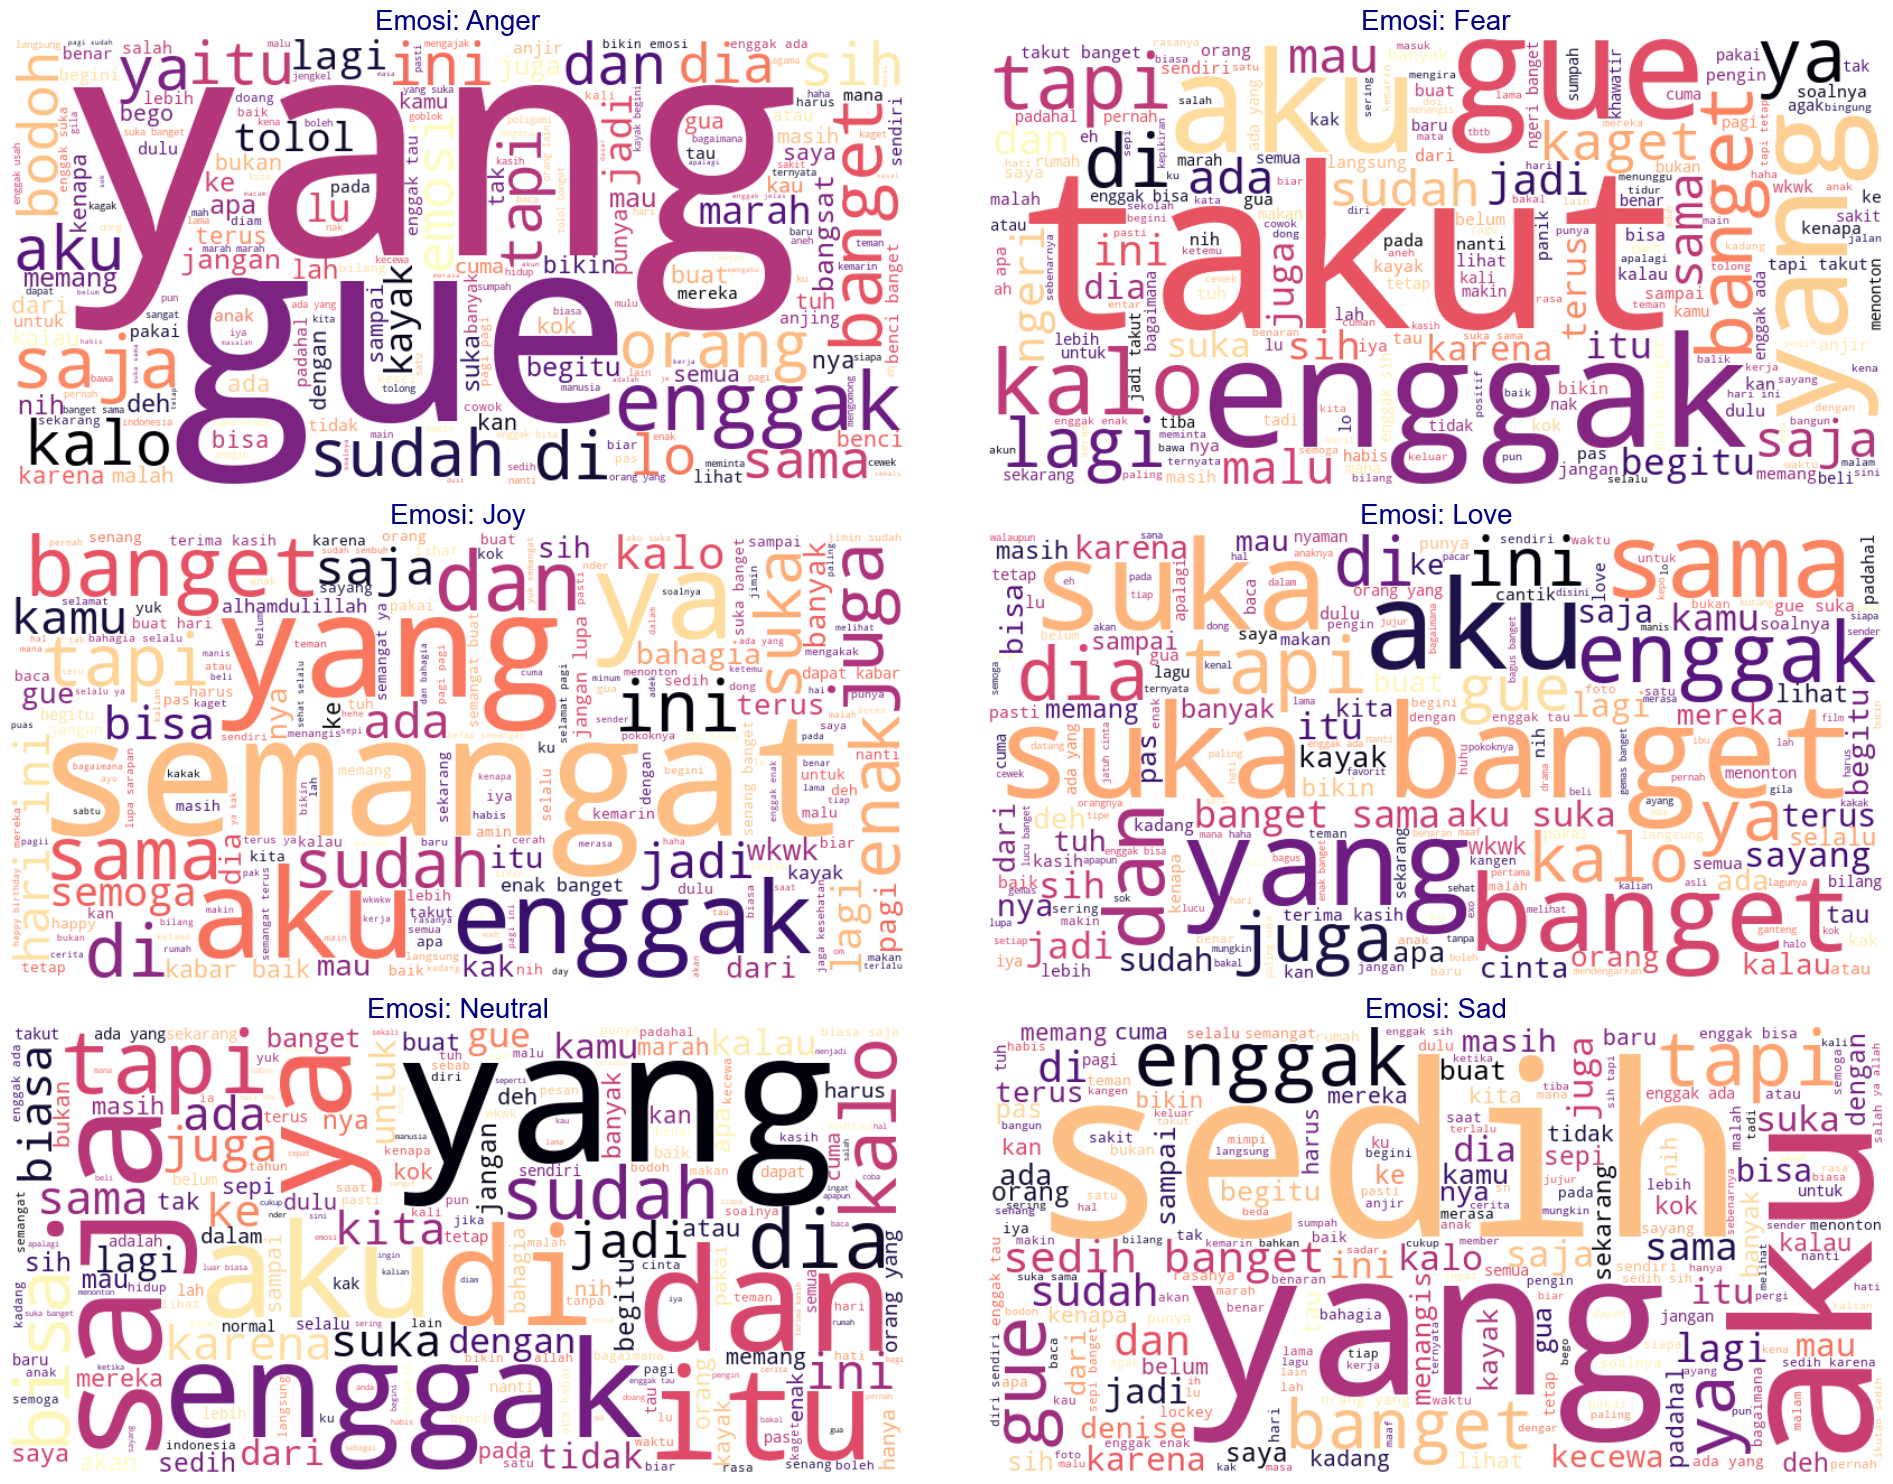

In [11]:
plt.figure(figsize=(20, 15))
unique_labels = sorted(full_df['label'].unique())

for i, label_code in enumerate(unique_labels):
    subset_text = " ".join(full_df[full_df['label'] == label_code]['text_clean'])
    wc = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(subset_text)
    # Plot di subplot grid
    plt.subplot(3, 2, i+1) # Sesuaikan grid (misal 3 baris x 2 kolom = 6 plot)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Emosi: {reverse_map[label_code]}", fontsize=20, color='navy')

plt.tight_layout()
plt.show()

### 4.4 N-Gram Analysis (Bigram & Trigram)

C:\Users\Victus\AppData\Local\Temp\ipykernel_2736\328186408.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette='viridis')
C:\Users\Victus\AppData\Local\Temp\ipykernel_2736\328186408.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette='magma')


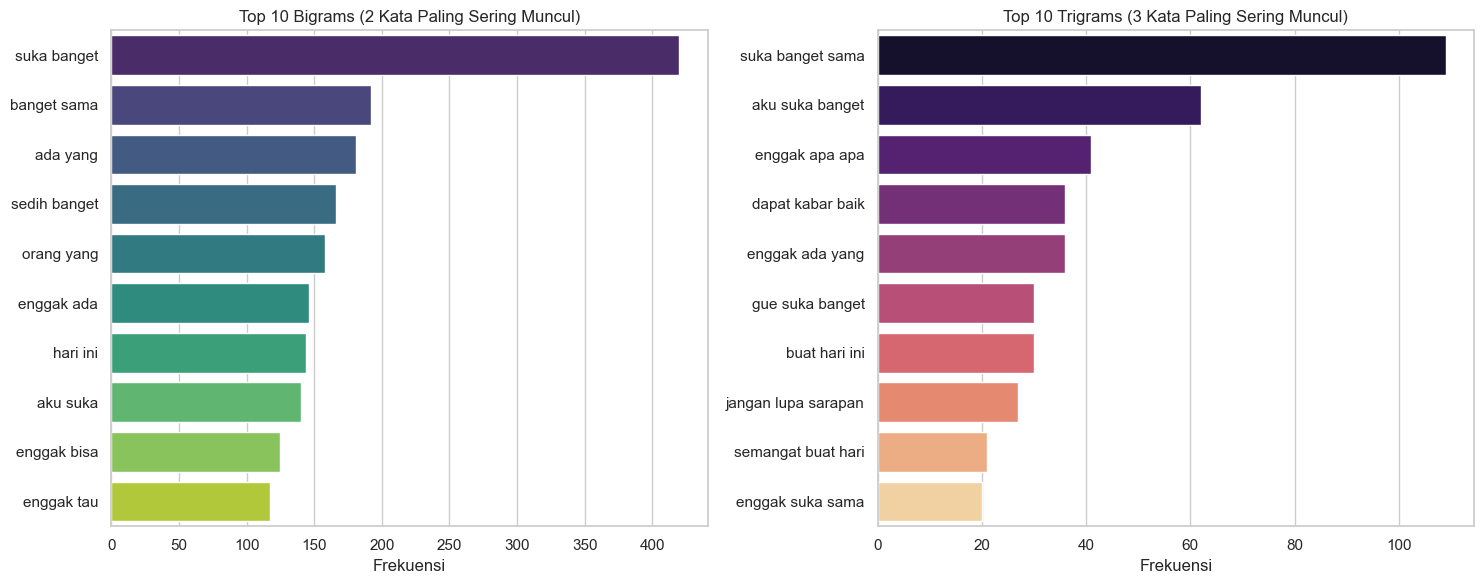


=== Cek Frase Khas per Emosi ===
Top Bigram untuk Anger: [('benci banget', 37), ('enggak tau', 32), ('enggak ada', 32), ('enggak suka', 29), ('bikin emosi', 29)]
Top Bigram untuk Fear: [('takut banget', 53), ('tapi takut', 39), ('malu banget', 25), ('enggak bisa', 23), ('takut enggak', 21)]


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Fungsi helper untuk mengambil top N-gram
def get_top_ngram(corpus, n=None, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# === Visualisasi ===
plt.figure(figsize=(15, 6))

# 1. Top 10 Bigrams (2 Kata)
plt.subplot(1, 2, 1)
top_bigrams = get_top_ngram(full_df['text_clean'], n=2, top_k=10)
x, y = map(list, zip(*top_bigrams))
sns.barplot(x=y, y=x, palette='viridis')
plt.title("Top 10 Bigrams (2 Kata Paling Sering Muncul)")
plt.xlabel("Frekuensi")

# 2. Top 10 Trigrams (3 Kata)
plt.subplot(1, 2, 2)
top_trigrams = get_top_ngram(full_df['text_clean'], n=3, top_k=10)
x, y = map(list, zip(*top_trigrams))
sns.barplot(x=y, y=x, palette='magma')
plt.title("Top 10 Trigrams (3 Kata Paling Sering Muncul)")
plt.xlabel("Frekuensi")

plt.tight_layout()
plt.show()

# === Cek Bigram Spesifik per Emosi (Opsional tapi Keren) ===
# Contoh: Kita ingin lihat Bigram khusus untuk emosi 'Anger' (Label 0) vs 'Joy' (Label 1)
print("\n=== Cek Frase Khas per Emosi ===")
for label_id, label_text in reverse_map.items():
    if label_id in [0, 1]: # Cek Anger dan Joy saja sebagai sampel
        subset = full_df[full_df['label'] == label_id]['text_clean']
        if len(subset) > 0:
            top_bi = get_top_ngram(subset, n=2, top_k=5)
            print(f"Top Bigram untuk {label_text}: {top_bi}")

## **5. Data Spliting**

### 5.1 Train - Validation -Test Split

In [13]:
# 1. Split Pertama: Pisahkan 80% Train dan 20% Sisanya (Temp)
# stratify=full_df['label'] -> Memastikan proporsi label seimbang
train_df, temp_df = train_test_split(full_df, 
                                     test_size=0.2, 
                                     random_state=42, 
                                     stratify=full_df['label'])

# 2. Split Kedua: Bagi 20% Sisanya menjadi 50:50 (Val & Test)
# Jadi masing-masing dapat 10% dari total awal
val_df, test_df = train_test_split(temp_df, 
                                   test_size=0.5, 
                                   random_state=42, 
                                   stratify=temp_df['label'])

### 5.2 Final Check

In [14]:
import pandas as pd
from IPython.display import display

print("=== Cek Konsistensi Distribusi Semua Kelas ===")

# 1. Definisikan Nama Label lagi (biar di tabel muncul nama, bukan angka)
label_names = {
    0: 'Anger', 
    1: 'Fear', 
    2: 'Joy', 
    3: 'Love', 
    4: 'Neutral', 
    5: 'Sad'
}

# 2. Fungsi hitung persentase
def get_distribution(df):
    # value_counts(normalize=True) otomatis menghitung persentase (0.0 - 1.0)
    # Kita kali 100 biar jadi persen (%)
    dist = df['label'].value_counts(normalize=True).sort_index() * 100
    return dist

# 3. Gabungkan hasil hitungan ke satu Tabel DataFrame
comparison_df = pd.DataFrame({
    'Full Data (%)': get_distribution(full_df),
    'Train Set (%)': get_distribution(train_df),
    'Val Set (%)':   get_distribution(val_df),
    'Test Set (%)':  get_distribution(test_df)
})

# 4. Ganti Index angka (0,1,2) jadi nama (Anger, Joy, dst)
comparison_df.index = comparison_df.index.map(label_names)

# 5. Tampilkan (Bulatkan 2 angka desimal biar rapi)
display(comparison_df.round(2))

=== Cek Konsistensi Distribusi Semua Kelas ===


,Full Data (%),Train Set (%),Val Set (%),Test Set (%)
label,,,,
Anger,16.09,16.09,16.09,16.09
Fear,13.00,13.01,12.90,13.04
Joy,17.87,17.87,17.97,17.83
Love,10.74,10.75,10.72,10.72
Neutral,28.17,28.16,28.26,28.12
Sad,14.12,14.12,14.06,14.20


## **6. Export Processed Data**

In [15]:
# Tentukan lokasi penyimpanan (gunakan ../ agar keluar dari folder notebooks)
output_folder = '../Datasets/processed/'
os.makedirs(output_folder, exist_ok=True)

# Fungsi helper untuk menyimpan CSV
def save_data(df, filename):
    path = os.path.join(output_folder, filename)
    # Ambil hanya kolom text bersih dan label, lalu rename
    final_data = df[['text_clean', 'label']].rename(columns={'text_clean': 'text'})
    final_data.to_csv(path, index=False)
    print(f"💾 Tersimpan: {path}")

# 1. Simpan CSV
print("=== Exporting Data ===")
save_data(train_df, 'train.csv')
save_data(val_df, 'val.csv')
save_data(test_df, 'test.csv')

# 2. Simpan Label Map (Penting buat nanti saat Prediksi/Inference)
# Agar kita ingat 0 itu apa, 1 itu apa.
with open(os.path.join(output_folder, 'label_map.json'), 'w') as f:
    json.dump(label_map, f)
print("💾 Tersimpan: label_map.json")

print("\n✅ SELESAI!")

=== Exporting Data ===
💾 Tersimpan: ../Datasets/processed/train.csv
💾 Tersimpan: ../Datasets/processed/val.csv
💾 Tersimpan: ../Datasets/processed/test.csv
💾 Tersimpan: label_map.json

✅ SELESAI!
